<a href="https://colab.research.google.com/github/david-levin11/Verification_Notebooks/blob/main/PlotHRRR_AK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objective: To plot archived HRRR data for AK**
<br/>
Description--This script will attempt to use the Herbie python package to download and plot HRRR AK data for case reviews/operational recaps.

- David Levin, Arctic Testbed & Proving Ground, Anchorage Alaska

##**2 - Install and Import Packages**
This will take about a minute to run.

In [21]:
# @title
!pip install ecmwflibs
!pip install eccodes
!pip install cfgrib
!pip install curl
!pip install eccodes
!pip install wgrib2
!pip install herbie-data[extras]
from herbie import Herbie
from herbie.toolbox import EasyMap, pc
from herbie import paint
import matplotlib.pyplot as plt



ERROR: Could not find a version that satisfies the requirement curl (from versions: none)
ERROR: No matching distribution found for curl
ERROR: Could not find a version that satisfies the requirement wgrib2 (from versions: none)
ERROR: No matching distribution found for wgrib2


##**3 - Download & Plot**

<ipython-input-114-330c958def5b>:24: UserWarning: Overwriting the cmap 'nws.pcp' that was already in the registry.
  mpl.colormaps.register(cmap=cm, force=True)
<ipython-input-114-330c958def5b>:25: UserWarning: Overwriting the cmap 'nws.pcp_r' that was already in the registry.
  mpl.colormaps.register(cmap=cm.reversed(), force=True)
<ipython-input-114-330c958def5b>:24: UserWarning: Overwriting the cmap 'nws.pcp2' that was already in the registry.
  mpl.colormaps.register(cmap=cm, force=True)
<ipython-input-114-330c958def5b>:25: UserWarning: Overwriting the cmap 'nws.pcp2_r' that was already in the registry.
  mpl.colormaps.register(cmap=cm.reversed(), force=True)


✅ Found ┊ model=hrrrak ┊ product=sfc ┊ 2024-Jun-27 12:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrrak ┊ product=sfc ┊ 2024-Jun-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
ds.tp.GRIB_stepRange='0-6'


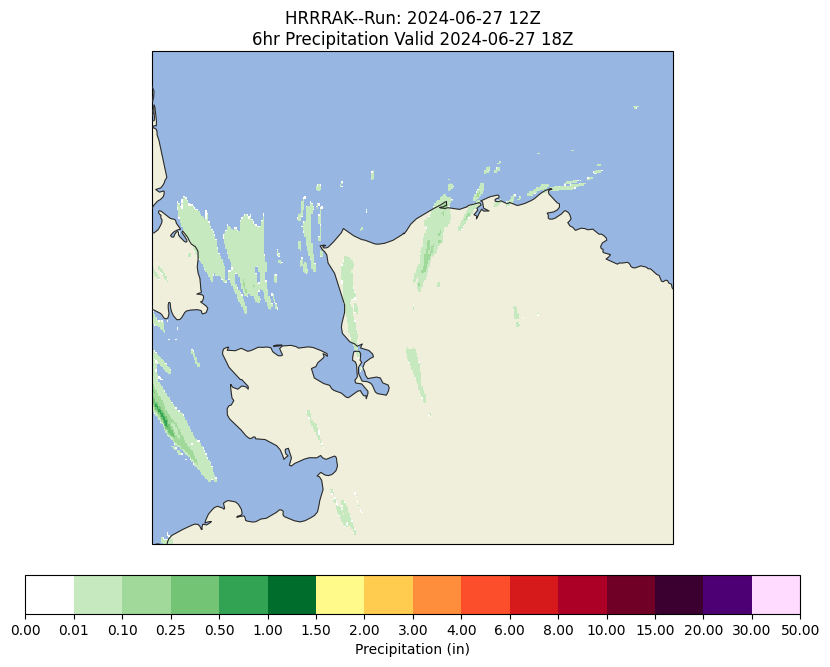

In [114]:


try:
    import numpy as np
    from datetime import datetime, timedelta
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
except ImportError:
    raise ImportError("herbie.paint requires matplotlib.")

# setting up our colorscales for plotting precip since Herbie only uses mm
# can use paint for everything else

def make_custom_cmaps(name, colors, bounds: list = None, N: int = None):
    if N is None:
        N = len(colors)
    linear_cmap = mcolors.LinearSegmentedColormap.from_list(name, colors)
    segment_cmap = mcolors.LinearSegmentedColormap.from_list(name + "2", colors, N=N)

    # When data is NaN, set color to transparent
    linear_cmap.set_bad("#ffffff00")
    segment_cmap.set_bad("#ffffff00")

    for cm in [linear_cmap, segment_cmap]:
        mpl.colormaps.register(cmap=cm, force=True)
        mpl.colormaps.register(cmap=cm.reversed(), force=True)

    if bounds is not None:
        return (
            mcolors.Normalize(bounds.min(), bounds.max()),
            mcolors.BoundaryNorm(bounds, linear_cmap.N),
        )

class NWSPrecipitation:
    """National Weather Service precipitation amount colorbar properties.

    Also known as Qualitative Precipitation Forecast/Estimate (QPF/QPE).
    """

    name = "nws.pcp"
    units = "in"
    variable = "Precipitation"
    colors = np.array(
        [
            "#ffffff",
            "#c7e9c0",
            "#a1d99b",
            "#74c476",
            "#31a353",
            "#006d2c",
            "#fffa8a",
            "#ffcc4f",
            "#fe8d3c",
            "#fc4e2a",
            "#d61a1c",
            "#ad0026",
            "#700026",
            "#3b0030",
            "#4c0073",
            "#ffdbff",
        ]
    )
    # NWS bounds in inches
    bounds = np.array(
        [0, 0.01, 0.1, 0.25, 0.5, 1, 1.5, 2, 3, 4, 6, 8, 10, 15, 20, 30, 50]
    )
    norm, norm2 = make_custom_cmaps(name, colors, bounds)
    cmap = plt.get_cmap(name)
    cmap2 = plt.get_cmap(name + "2")
    kwargs = dict(cmap=cmap, norm=norm)
    kwargs2 = dict(cmap=cmap, norm=norm2)
    cbar_kwargs = dict(label=f"{variable} ({units})")
    cbar_kwargs2 = cbar_kwargs | dict(spacing="uniform", ticks=bounds)
'''
# Get a list of all colormap names
colormaps = plt.colormaps()

# Print each colormap name
for cmap in colormaps:
    print(cmap)
'''

##################### Config ##############################################

model = "hrrrak"
#@markdown Choose Model Run Date
rundate = "2024-06-27" #@param {type:"date"}
#@markdown Choose Model Run Hour (UTC)
hour = 12 #@param {type:"slider", min:0, max:21, step:3}

runhour = str(hour).zfill(2)

runstring = rundate + " " +runhour + ":00"

run_time = rundate + " " +runhour + "Z"
#@markdown Choose your forecast time step
fcst_hr = 6 #@param {type:"slider", min:0, max:48, step:3}

valid_time = (datetime.strptime(runstring, "%Y-%m-%d %H:%M") + timedelta(hours=fcst_hr)).strftime("%Y-%m-%d %HZ")

#@markdown Choose your weather element to plot (current choices are: 6hrPrecip, 1hrPrecip, 2mTemp, Reflectivity)
element = "6hrPrecip" #@param {type:"string"}

element_list = ["6hrPrecip","1hrPrecip","2mTemp","Reflectivity"]

if element not in element_list:
  raise ValueError(f"Element must be one of {element_list}")

product = "sfc"

#@markdown Would you like to have a custom zoom?  If so, check the box and enter appropriate values for lat/lons below
#@markdown Default is all of AK
custom_extent = True #@param {type:"boolean"}

if custom_extent:
  west = -171.00 #@param {type:"number"}
  north = 72.00 #@param {type:"number"}
  east = -149.00 #@param {type:"number"}
  south = 65.00 #@param {type:"number"}
################################# Main Code ################################

# logic for selecting variables
if element == "1hrPrecip":
  # getting the correct run based on inputs
  H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
  ds = H.xarray(":APCP:.*:(?:0-1|[1-9]\d*-\d+) hour")
  oldvar = ds.tp/25.4
  var = oldvar.where(oldvar>0.009)
  name = f"1hr {ds.tp.GRIB_name.split(' ')[-1]}"
  description = ds.description
  kwargs = NWSPrecipitation.kwargs2
  cbar_kwargs = NWSPrecipitation.cbar_kwargs2

elif element == "6hrPrecip":
  try:
  #have to subtract the previous total precip accum from the current
  #This won't work unless we have both time steps
    H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
    H2 = Herbie(rundate, model=model, product=product, fxx=fcst_hr-6)
    ds = H.xarray(":APCP:surface:0-[1-9]*")
    ds2 = H2.xarray(":APCP:surface:0-[1-9]*")
    oldvar = (ds.tp - ds2.tp)/25.4
    var = oldvar.where(oldvar>0.009)
    name = f"6hr {ds.tp.GRIB_name.split(' ')[-1]}"
    description = ds.description
    kwargs = NWSPrecipitation.kwargs2
    cbar_kwargs = NWSPrecipitation.cbar_kwargs2

  except Exception as e:
    print(e)
elif element == "2mTemp":
  H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
  ds = H.xarray(":TMP:2 m above")
  var = ds.t2m-273.15
  name = ds.tp.GRIB_name
  description = ds.product_description
  kwargs = paint.NWSTemperature.kwargs2
  cbar_kwargs = paint.NWSTemperature.cbar_kwargs2

elif element == "Reflectivity":
  H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
  ds = H.xarray(":REFC:")
  var = ds.refc
  name = ds.refc.GRIB_name
  description = ds.description
  #kwargs = paint.NWSRefectivity.kwargs2
  #cbar_kwargs = paint.NWSReflectivity.cbar_kwargs2

modelname = ds.model.upper()

#print(ds)
if "Precip" in element:
  print(f"{ds.tp.GRIB_stepRange=}")

ax = EasyMap("50m", crs=ds.herbie.crs, figsize=[10,8]).STATES().OCEAN().LAND().ax

# setting custom extent if necessary
if custom_extent:
  ax.set_extent([west, east, south, north])
if element != "Reflectivity":
  p = ax.pcolormesh(ds.longitude, ds.latitude, var, transform=pc, **kwargs)

  plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05, **cbar_kwargs)

  ax.set_title(f"{modelname}--Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)

else:
  # don't need negative or 0 Reflectivity values
  newvar = var.where(var>0)
  p = ax.pcolormesh(ds.longitude, ds.latitude, newvar, transform=pc, cmap='radar.reflectivity', vmin=0, vmax=70)

  plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)

  ax.set_title(f"{modelname}--Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)

plt.show()

